In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0
410,410,1.024,5.53,577,19.7,224,0.77,0
411,411,1.018,6.28,455,22.2,270,7.68,1
412,412,1.008,7.12,325,12.6,75,1.03,1


In [4]:
#z score normalization
cols=['gravity','ph','osmo','cond','urea','calc']
for i in cols:
    df[i]=((df[i]-np.mean(df[i]))/np.std(df[i]))

In [5]:
X=df.drop(['id','target'],axis=1)
Y=df['target']

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,train_size=0.80,shuffle=True)

In [19]:
from keras.layers import Dense,Flatten,BatchNormalization,Input,Dropout
from keras.models import Model

In [20]:


def scheduler(epochs,lr):
    if(epochs<10):
        return lr
    else:
        return lr*tf.math.exp(-0.01*epochs)

In [21]:
#Neural network architecture
def model_creation():
    input_layer=Input((6,))

    #create the dense layers
    dense0=Dense(32,activation='tanh',kernel_initializer='glorot_uniform')(input_layer)
    dense=BatchNormalization()(dense0)

    dense1=Dense(64,activation='tanh',kernel_initializer='glorot_uniform')(dense0)
    dense1=BatchNormalization()(dense1)

    dense2=Dense(128,activation='tanh',kernel_initializer='glorot_uniform')(dense1)
    dense2=BatchNormalization()(dense2)

    dense3=Dense(256,activation='tanh',kernel_initializer='glorot_uniform')(dense2)
    dense3=BatchNormalization()(dense3)
    dense3=Dropout(rate=0.2)(dense3)
    
    dense4=Dense(128,activation='tanh',kernel_initializer='glorot_uniform')(dense3)
    dense4=BatchNormalization()(dense4)

    dense5=Dense(64,activation='tanh',kernel_initializer='glorot_uniform')(dense4)
    dense5=BatchNormalization()(dense5)

    dense6=Dense(32,activation='relu',kernel_initializer='glorot_uniform')(dense5)
    dense6=BatchNormalization()(dense6)

    output=Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform')(dense5)

    model=Model(inputs=input_layer,outputs=output)

    return model

In [22]:
model=model_creation()

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_8 (Dense)             (None, 32)                224       
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                           

In [24]:
#Set the hyperparameters for model
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy,MeanAbsoluteError,RootMeanSquaredError,MeanSquaredError
from keras.losses import BinaryCrossentropy

model.compile(optimizer=Adam(learning_rate=0.001),loss=BinaryCrossentropy(),metrics=[BinaryAccuracy(),MeanAbsoluteError(),MeanSquaredError(),RootMeanSquaredError()])


In [25]:
#Write a learning rate scheduler
scheduler_callback=tf.keras.callbacks.LearningRateScheduler(scheduler)

In [26]:
learning=model.fit(x_train,y_train,epochs=300,batch_size=16,verbose=1,validation_data=(x_test,y_test),callbacks=[scheduler_callback])

Epoch 1/300
21/21 [==============================] - 4s 47ms/step - loss: 0.6828 - binary_accuracy: 0.6918 - mean_absolute_error: 0.3767 - mean_squared_error: 0.2244 - root_mean_squared_error: 0.4737 - val_loss: 0.6276 - val_binary_accuracy: 0.6867 - val_mean_absolute_error: 0.4387 - val_mean_squared_error: 0.2184 - val_root_mean_squared_error: 0.4674 - lr: 0.0010
Epoch 2/300
21/21 [==============================] - 0s 11ms/step - loss: 0.5854 - binary_accuracy: 0.7492 - mean_absolute_error: 0.3651 - mean_squared_error: 0.1941 - root_mean_squared_error: 0.4405 - val_loss: 0.6557 - val_binary_accuracy: 0.6145 - val_mean_absolute_error: 0.4530 - val_mean_squared_error: 0.2320 - val_root_mean_squared_error: 0.4817 - lr: 0.0010
Epoch 3/300
21/21 [==============================] - 0s 10ms/step - loss: 0.6177 - binary_accuracy: 0.7130 - mean_absolute_error: 0.3553 - mean_squared_error: 0.2036 - root_mean_squared_error: 0.4512 - val_loss: 0.6475 - val_binary_accuracy: 0.6747 - val_mean_absolu

In [27]:
import matplotlib.pyplot as plt

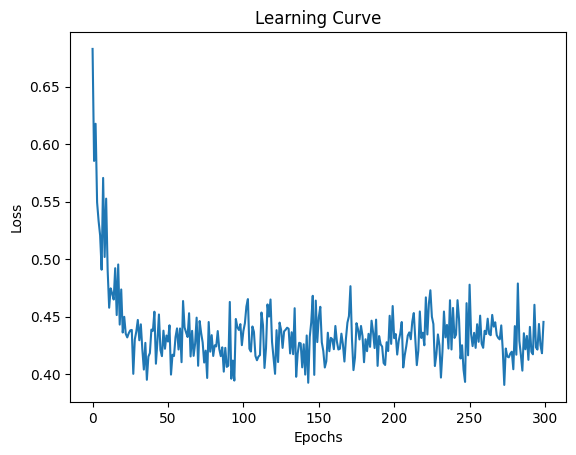

In [28]:
plt.plot(learning.history['loss'])
#plt.plot(learning.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.show()

Text(0, 0.5, 'Accuracy')

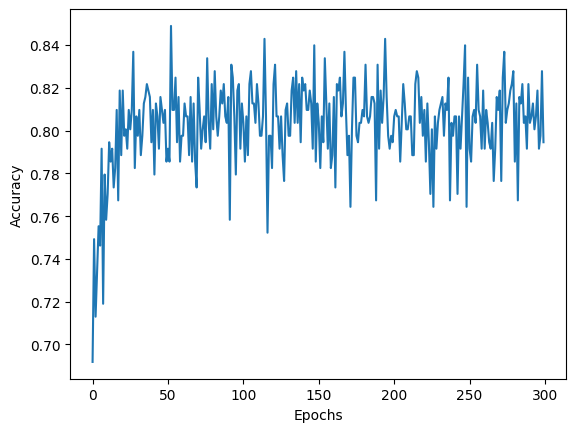

In [29]:
plt.plot(learning.history['binary_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [46]:
#confusion matrix
#Training and testing
p=model.predict(x_test)

3/3 [==============================] - 0s 4ms/step


In [47]:
p[p>=0.5]=1
p[p<0.5]=0

In [49]:
from sklearn.metrics import confusion_matrix
m=confusion_matrix(y_test,p)

In [50]:
m

array([[31, 11],
       [18, 23]], dtype=int64)

In [51]:
#PPV
ppv=(m[0][0])/(m[0][0]+m[1][0])
specificity=(m[1][1])/(m[1][1]+m[0][1])


In [52]:
ppv,specificity

(0.6326530612244898, 0.6764705882352942)